# ISE 540 Final Project
# Yelp Review - Fine Dining Restaurant Analysis

Team Power Four

Team members: 
Yan Gong, Boyang Li, Meihua Li, Huiming Zhang

In [73]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import os
from numpy import *
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import tqdm
import tmtoolkit
from tmtoolkit.topicmod.evaluate import results_by_parameter
import pyLDAvis
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.utils import ClippedCorpus
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\limei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\limei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
from datetime import datetime
start_time = datetime.now()
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle as reset
from sklearn.metrics import classification_report
%matplotlib inline
from scipy import stats
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
import math

from sklearn.linear_model import LogisticRegression
import matplotlib.cbook as cbook
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import xgboost as xgb
import lightgbm as lgb
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn import metrics
import sys
from PIL import Image
import io
import plotly.offline as py 
py.init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import plotly.tools as tls 
import plotly.figure_factory as ff 

## Read json files

In [77]:
business_json_path = 'yelp_academic_dataset_business.json'
df_b = pd.read_json(business_json_path, lines=True)

### Select categories as Restaurant

In [78]:
df_b = df_b[df_b['categories'].str.contains('Restaurant')==True]

### Find the city with the most business parties

In [79]:
business_city=df_b['city'].value_counts()
business_city.sort_values(ascending=False)

Las Vegas            31631
Toronto              20366
Phoenix              20171
Charlotte            10422
Scottsdale            9342
                     ...  
Central Henderson        1
Scarobrough              1
Sandy Ridge              1
Apache Trail             1
Parma mid birth          1
Name: city, Length: 1251, dtype: int64

In [80]:
review_json_path = 'yelp_academic_dataset_review.json'
size = 1000000
df_review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,'funny':int,'cool':int},chunksize = size)
chunk_list = []
count = 0
for chunk in df_review:
    chunk = chunk.rename(columns={'stars': 'review_stars'})
    chunk_merged = pd.merge(df_b, chunk, on='business_id', how='inner')
    if count == 0:
        df_review1 = chunk_merged
    if count >= 1:
        df_review1 = pd.concat([df_review1, chunk_merged])
    count += 1

In [81]:
las_vegas = df_review1[df_review1['city'] == 'Las Vegas']

In [82]:
RestaurantsPriceRange=[]
for i in range(len(las_vegas)):
    tmp=las_vegas.iloc[i]['attributes']
    try:
        tmp_dict=eval(tmp)
        tmp=tmp_dict['RestaurantsPriceRange2']
        RestaurantsPriceRange.append(tmp)
    except:
        RestaurantsPriceRange.append('NAN')

In [83]:
las_vegas['RestaurantsPriceRange']=RestaurantsPriceRange

### Sampling: 15%

In [84]:
lv_fourstar=las_vegas[las_vegas['RestaurantsPriceRange']=='4']
lv_fourstar=lv_fourstar.sample(frac=0.15, replace=False, random_state=1)

In [85]:
lv_nonfourstar=las_vegas[las_vegas['RestaurantsPriceRange']!='4']
lv_nonfourstar=lv_nonfourstar.sample(frac=0.15, replace=False, random_state=1)

In [86]:
las_vegas_copy=pd.concat([lv_nonfourstar, lv_fourstar])

In [88]:
las_vegas_copy.head()

,Unnamed: 0,Unnamed: 0.1,address,attributes,business_id,categories,city,hours,is_open,latitude,...,state,cool,date,funny,review_id,review_stars,text,useful,user_id,RestaurantsPriceRange
0,0,120,"6870 S Rainbow Blvd, Ste 117","{'BusinessParking': ""{'garage': False, 'street...",oiAlXZPIFm2nBCt0DHLu_Q,"Dry Cleaning & Laundry, Local Services, Laundr...",Las Vegas,"{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",1,36.063977,...,NV,1,2016-06-23 05:50:54,0,9bMxu3-RCv0ncYnNNNkbWg,5,I've been coming to this dry cleaner for almos...,3,IMguz1Z9dp8HG0UfeLEdEg,1
1,1,121,"6870 S Rainbow Blvd, Ste 117","{'BusinessParking': ""{'garage': False, 'street...",oiAlXZPIFm2nBCt0DHLu_Q,"Dry Cleaning & Laundry, Local Services, Laundr...",Las Vegas,"{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",1,36.063977,...,NV,0,2011-10-27 23:35:10,0,b-B3ycJZmOTP5EdWTwCsMA,1,They lost 2 pairs of my suitpants and told me ...,1,_TAVpa1Y2_5KZ5wWYeX_6g,1
2,2,122,"6870 S Rainbow Blvd, Ste 117","{'BusinessParking': ""{'garage': False, 'street...",oiAlXZPIFm2nBCt0DHLu_Q,"Dry Cleaning & Laundry, Local Services, Laundr...",Las Vegas,"{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",1,36.063977,...,NV,0,2013-07-13 03:25:04,0,MaIIb4Er_LuqN3zSSdA06w,5,I have been going to this dry cleaning since I...,1,45R6BBybzwDuJaL08d1myQ,1
3,3,123,"6870 S Rainbow Blvd, Ste 117","{'BusinessParking': ""{'garage': False, 'street...",oiAlXZPIFm2nBCt0DHLu_Q,"Dry Cleaning & Laundry, Local Services, Laundr...",Las Vegas,"{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",1,36.063977,...,NV,1,2016-06-23 01:58:09,1,RALKX860sppIq-oxsSFhqQ,1,I've only had my dry cleaning done here twice ...,4,7iziCsP2MkHMmckpYVPSDg,1
4,4,124,"6870 S Rainbow Blvd, Ste 117","{'BusinessParking': ""{'garage': False, 'street...",oiAlXZPIFm2nBCt0DHLu_Q,"Dry Cleaning & Laundry, Local Services, Laundr...",Las Vegas,"{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",1,36.063977,...,NV,1,2012-09-12 20:38:40,1,zmueCMXpF3v2Gz2Szxq01g,5,After reading the reviews of the cleaners clos...,3,Yg08tRMxm0eaL-rXyNIAHw,1


In [89]:
las_vegas_copy.loc[(las_vegas_copy['RestaurantsPriceRange']=='4'), 'RestaurantsPriceRange'] = 1

In [90]:
las_vegas_copy.loc[(las_vegas_copy['RestaurantsPriceRange']!= 1), 'RestaurantsPriceRange'] = 0

### Tokenize by Sentence

In [93]:
def tokenize(review):
    try:
        return sent_tokenize(review)
    except:
        return ''  

In [94]:
las_vegas_copy['tokenize'] = las_vegas_copy['text'].apply(tokenize)
df_tokenize = pd.DataFrame(las_vegas_copy.set_index(['review_id'])['tokenize'].apply(pd.Series).stack()).reset_index()
df_tokenize.head()

,review_id,level_1,0
0,v7jLgsmYo9J-Cd1vn-yMnw,0,Did you see the BEAUTIFUL BLONDE'S that are Ba...
1,v7jLgsmYo9J-Cd1vn-yMnw,1,OMG.
2,v7jLgsmYo9J-Cd1vn-yMnw,2,This place is Great.
3,v7jLgsmYo9J-Cd1vn-yMnw,3,Really good Food.
4,v7jLgsmYo9J-Cd1vn-yMnw,4,Tip well its worth it.


In [95]:
df_tokenize.columns = ['review_id', 'level_1', 'sentence']

In [96]:
df_tokenize = df_tokenize.drop("level_1", axis=1).head()

In [97]:
df_tokenize.head()

,review_id,sentence
0,v7jLgsmYo9J-Cd1vn-yMnw,Did you see the BEAUTIFUL BLONDE'S that are Ba...
1,v7jLgsmYo9J-Cd1vn-yMnw,OMG.
2,v7jLgsmYo9J-Cd1vn-yMnw,This place is Great.
3,v7jLgsmYo9J-Cd1vn-yMnw,Really good Food.
4,v7jLgsmYo9J-Cd1vn-yMnw,Tip well its worth it.


In [98]:
las_vegas_tokenize = pd.merge(las_vegas_copy, df_tokenize, on = 'review_id', how='inner')

### Sentiment Polarity

In [99]:
def sentiment(review):
    try:
        return TextBlob(text).sentiment[0]
    except:
        return 0

In [100]:
las_vegas_tokenize['polarity'] = las_vegas_tokenize['sentence'].apply(sentiment)

In [101]:
las_vegas_tokenize.head()

,Unnamed: 0,Unnamed: 0.1,address,attributes,business_id,categories,city,hours,is_open,latitude,...,funny,review_id,review_stars,text,useful,user_id,RestaurantsPriceRange,tokenize,sentence,polarity
0,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,1,v7jLgsmYo9J-Cd1vn-yMnw,5,Did you see the BEAUTIFUL BLONDE'S that are Ba...,1,qxMpivZxjSVMV633w5elHQ,0,[Did you see the BEAUTIFUL BLONDE'S that are B...,Did you see the BEAUTIFUL BLONDE'S that are Ba...,0
1,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,1,v7jLgsmYo9J-Cd1vn-yMnw,5,Did you see the BEAUTIFUL BLONDE'S that are Ba...,1,qxMpivZxjSVMV633w5elHQ,0,[Did you see the BEAUTIFUL BLONDE'S that are B...,OMG.,0
2,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,1,v7jLgsmYo9J-Cd1vn-yMnw,5,Did you see the BEAUTIFUL BLONDE'S that are Ba...,1,qxMpivZxjSVMV633w5elHQ,0,[Did you see the BEAUTIFUL BLONDE'S that are B...,This place is Great.,0
3,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,1,v7jLgsmYo9J-Cd1vn-yMnw,5,Did you see the BEAUTIFUL BLONDE'S that are Ba...,1,qxMpivZxjSVMV633w5elHQ,0,[Did you see the BEAUTIFUL BLONDE'S that are B...,Really good Food.,0
4,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,1,v7jLgsmYo9J-Cd1vn-yMnw,5,Did you see the BEAUTIFUL BLONDE'S that are Ba...,1,qxMpivZxjSVMV633w5elHQ,0,[Did you see the BEAUTIFUL BLONDE'S that are B...,Tip well its worth it.,0


### LDA Topics

In [102]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True)) 
sentence_list = las_vegas_tokenize.sentence.values.tolist()
word_list = list(sent_to_words(sentence_list))

In [103]:
stop_words = list(stopwords.words("english"))
def remove_stopwords(reviews):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in reviews]

In [104]:
re_stop = remove_stopwords(word_list)

In [105]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(las_vegas_tokenize['sentence'])

In [106]:
def lda_topics(model, count_vectorizer, number_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-number_words - 1:-1]]))

### A simple LDA model

In [107]:
lda = LDA(n_components=5, n_jobs=-1)
lda.fit(count_data)

lda_topics(lda, count_vectorizer, 10)

Topic #0:
food did blonde beautiful great place omg worth tip really

Topic #1:
really good food omg worth tip place great did service

Topic #2:
place great omg worth nice did worth beautiful bartenders really

Topic #3:
friends creme room meat overrated really small actually went go

Topic #4:
nice dining place server time better menu went place


In [109]:
cv = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                                                         top_n=10, 
                                                         topic_word_distrib=lda.components_, 
                                                         vocab=np.array([x for x in count_vectorizer.vocabulary_.keys()]), 
                                                         texts=re_stop)

In [110]:
print('\nCoherence Score: ', mean([a_ for a_ in cv if a_ == a_]))


Coherence Score:  0.3039197795072706


### LDA Evaluation

In [111]:
def evaluate_lda(k, a, b):
    
    lda = LDA(n_components=k, n_jobs=-1, doc_topic_prior=a, topic_word_prior=b)
    lda.fit(count_data)
    cv = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                                                             top_n=10, 
                                                             topic_word_distrib=lda.components_, 
                                                             vocab=np.array([x for x in count_vectorizer.vocabulary_.keys()]), 
                                                             texts=re_stop)
    
    return mean([a_ for a_ in cv if a_ == a_])

In [112]:
topics = range(2, 15, 1)
alpha = list(np.arange(0.01, 1, 0.3))
beta = list(np.arange(0.01, 1, 0.3))
lda_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}
for k in topics:
    for a in alpha:
        for b in beta:
            cv = evaluate_lda(k=k, a=a, b=b)
            lda_results['Topics'].append(k)
            lda_results['Alpha'].append(a)
            lda_results['Beta'].append(b)
            lda_results['Coherence'].append(cv)                 
df_cv = pd.DataFrame(lda_results)

In [113]:
df_cv.sort_values(by='Coherence', ascending=False).head()

,Topics,Alpha,Beta,Coherence
131,10,0.01,0.91,0.348003
135,10,0.31,0.91,0.345971
139,10,0.61,0.91,0.342932
129,10,0.01,0.31,0.339691
134,10,0.31,0.61,0.336522
138,10,0.61,0.61,0.332967


#### The best LDA model with 10 topics, alpha 0.01, beta 0.91, has the highest coherence 0.348.

### Best LDA Topics and Top 10 Words

In [114]:
lda = LDA(n_components=10, n_jobs=-1, doc_topic_prior=0.01, topic_word_prior=0.91)
lda.fit(count_data)

lda_topics(lda, count_vectorizer, 10)

Topic #0:
food like burger cheese delicious nice restaurant said bread would

Topic #1:
great service place table wait love thing just prepared attentive

Topic #2:
good tasting wait go meal flavour vegas fresh really spicy

Topic #3:
amazing dinner chicken night come wife really expensive went day

Topic #4:
good staff menu service friendly got would chef better place

Topic #5:
did get wine fruit drink bar like water try cocktails

Topic #6:
taste great pretty dish quality ordered highly just worth got

Topic #7:
nice best experience well enjoy unique excellent meal long reservation

Topic #8:
pretty flavor star fried only alcoholic worth something go grilled

Topic #9:
happy nice expect differ atmosphere recommend hot ambiance got absolutely


### LDA weights

In [117]:
LDA_cols = ['LDA_' + str(i) for i in range(1, 11)]
LDA_weight = pd.DataFrame(lda.transform(count_data), columns = LDA_cols)

In [118]:
data = las_vegas_tokenize.join(LDA_weight)

In [119]:
data.head()

,Unnamed: 0,Unnamed: 0.1,address,attributes,business_id,categories,city,hours,is_open,latitude,...,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,LDA_9,LDA_10
0,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,0.002439,0.002439,0.002439,0.002439,0.002439,0.002439,0.002439,0.978049,0.002439,0.002439
1,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,0.009091,0.009091,0.009091,0.918182,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091
2,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,0.004762,0.957143,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762
3,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.970968,0.003226,0.003226,0.003226
4,226868,757880,921 N Buffalo Dr,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...",cWfqbkMit27-Pg_bPUTwCg,"Nightlife, Restaurants, American (Traditional)...",Las Vegas,NaN,1,36.182244,...,0.004762,0.004762,0.957143,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762


In [2]:
data = data.drop(columns=['user_id', 'Unnamed: 0','Unnamed: 0.1', 'address', 'attributes', 'business_id',
       'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude',
       'name', 'postal_code', 'state',  'date',
        'review_id', 'stars', 'text', 'sentence','cool', 'funny','useful'])

In [4]:
data.head()

,review_stars,RestaurantsPriceRange,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,LDA_9,LDA_10,polarity
0,4.0,0,0.119005,0.119661,0.119034,0.074797,0.059627,0.087034,0.098462,0.115522,0.092006,0.114851,0.174733
1,4.0,1,0.140470,0.078919,0.117682,0.080228,0.050698,0.137078,0.077352,0.093734,0.086634,0.137205,0.093752
2,4.0,0,0.090066,0.072611,0.109210,0.035707,0.079369,0.158485,0.079768,0.084985,0.149048,0.140752,0.269667
3,2.5,0,0.185746,0.032667,0.079737,0.081910,0.086758,0.069335,0.178575,0.101021,0.074919,0.109333,-0.004534
4,3.0,0,0.113157,0.027821,0.075322,0.195777,0.124964,0.035321,0.102235,0.128210,0.124250,0.072940,0.419861


In [7]:
def train_test_split(data, test_size, shuffle=True, random_state=None):
    if shuffle:
        data = reset(data, random_state=random_state)

    train = data[int(len(data)*test_size):].reset_index(drop = True)
    test  = data[:int(len(data)*test_size)].reset_index(drop = True)
    
    return train, test

In [8]:
train, validation = train_test_split(data, 0.1, shuffle=True, random_state=123)

In [9]:
Y = train['RestaurantsPriceRange']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size = 0.25, random_state = 101)

In [11]:
X_train.drop(columns=['RestaurantsPriceRange'], inplace=True)
X_test.drop(columns=['RestaurantsPriceRange'], inplace=True)

## Model

In [14]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [15]:
results_train = y_train.copy()
results_train.columns = ['y_actual']
results_test = y_test.copy()
results_test.columns = ['y_actual']

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [16]:
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict_proba(X_test)[:,1]

LOGCV_tr = metrics.roc_auc_score(y_train, logmodel.predict_proba(X_train)[:,1])
LOGCV_te = metrics.roc_auc_score(y_test, logmodel.predict_proba(X_test)[:,1])

LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

In [17]:
results_train['logreg'] = logmodel.predict_proba(X_train)[:,1]
results_test['logreg'] = logpred

In [18]:
logpred[logpred>0.5]=1
logpred[logpred<0.5]=0

In [19]:
y_test_pred = logmodel.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

In [20]:
LOGCV_f = metrics.f1_score(y_test, y_test_pred)

In [22]:
# find a good k for knn
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

#Neighbors
neighbors = np.arange(40,65,5)

#Create empty dataframe that will hold cv scores
knn_summary=pd.DataFrame(index=neighbors,columns=['roc_auc','std'])

#Perform 3-fold cross validation on training set for different values of k:
for k_value in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, n_jobs=-1)
    scores = cross_val_score(knn, X_train, y_train, cv=k_fold, scoring='roc_auc')
    knn_summary.loc[k_value,:]=[scores.mean()*100,scores.std()*100]
    print(k_value)

40
45
50
55
60


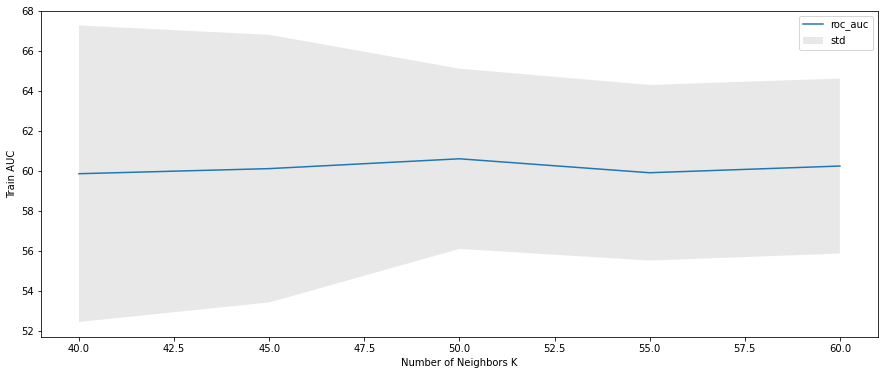

In [23]:
plt.figure(figsize=(15,6))
plt.plot(neighbors, knn_summary['roc_auc'],label='roc_auc')
plt.fill_between(neighbors,
                 (knn_summary['roc_auc']-knn_summary['std']).values.tolist(),
                 (knn_summary['roc_auc']+knn_summary['std']).values.tolist(),
                 facecolor='lightgrey', alpha=0.5, label='std')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train AUC')
plt.legend()
plt.show()

In [58]:
optimal_k = 45
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
KNNCV = (cross_val_score(knn, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['knn'] = knn.predict_proba(X_train)[:,1]
results_test['knn'] = knn.predict_proba(X_test)[:,1]

KNNCV_tr = metrics.roc_auc_score(y_train, knn.predict_proba(X_train)[:,1])
KNNCV_te = metrics.roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

y_test_pred = knn.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

KNNCV_f = metrics.f1_score(y_test, y_test_pred)

print(KNNCV)

0.8157657734450205


In [60]:
from sklearn.svm import SVC
svc= SVC(kernel = 'rbf', probability=True)
svc.fit(X_train, y_train)
SVCCV = (cross_val_score(svc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['svc'] = svc.predict_proba(X_train)[:,1]
results_test['svc'] =svc.predict_proba(X_test)[:,1]

SVCCV_tr = metrics.roc_auc_score(y_train, svc.predict_proba(X_train)[:,1])
SVCCV_te = metrics.roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

y_test_pred = svc.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

SVCCV_f = metrics.f1_score(y_test, y_test_pred)

print(SVCCV)

0.7563914941305216


In [61]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini',max_depth = 15,min_samples_leaf = 150, min_samples_split=100) #criterion = entopy, gini
dtree.fit(X_train, y_train)
DTREECV = (cross_val_score(dtree, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['dtree'] = dtree.predict_proba(X_train)[:,1]
results_test['dtree'] = dtree.predict_proba(X_test)[:,1]

DTREECV_tr = metrics.roc_auc_score(y_train, dtree.predict_proba(X_train)[:,1])
DTREECV_te = metrics.roc_auc_score(y_test, dtree.predict_proba(X_test)[:,1])

y_test_pred = dtree.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

DTREECV_f = metrics.f1_score(y_test, y_test_pred)

print(DTREECV)

0.7263531913160707


In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100,min_samples_split=100,min_samples_leaf=50,)#criterion = entopy,gini
rfc.fit(X_train, y_train)
RFCCV = (cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['rfc'] = rfc.predict_proba(X_train)[:,1]
results_test['rfc'] = rfc.predict_proba(X_test)[:,1]

RFCCV_tr = metrics.roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1])
RFCCV_te = metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])

y_test_pred = rfc.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

RFCCV_f = metrics.f1_score(y_test, y_test_pred)

print(RFCCV)

0.8296867743058605


In [63]:
from sklearn.naive_bayes import GaussianNB
gaussiannb= GaussianNB()
gaussiannb.fit(X_train, y_train)
gaussiannbpred = gaussiannb.predict_proba(X_test)[:,1]
probs = gaussiannb.predict_proba(X_test)[:,1]
GAUSSIANCV = (cross_val_score(gaussiannb, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['NB'] = gaussiannb.predict_proba(X_train)[:,1]
results_test['NB'] = gaussiannbpred

GAUSSIANCV_tr = metrics.roc_auc_score(y_train, gaussiannb.predict_proba(X_train)[:,1])
GAUSSIANCV_te = metrics.roc_auc_score(y_test, gaussiannb.predict_proba(X_test)[:,1])

y_test_pred = gaussiannb.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

GAUSSIANCV_f = metrics.f1_score(y_test, y_test_pred)

print(GAUSSIANCV)

0.7386053342589713


In [64]:
from xgboost import XGBClassifier
xb = XGBClassifier(max_depth=3,eval_metric='auc',min_child_weight=5)
xb.fit(X_train, y_train)
XGBCV = (cross_val_score(estimator = xb, X = X_train, y = y_train, cv = 10).mean())
results_train['xgb'] = xb.predict_proba(X_train)[:,1]
results_test['xgb'] = xb.predict_proba(X_test)[:,1]

XGBCV_tr = metrics.roc_auc_score(y_train, xb.predict_proba(X_train)[:,1])
XGBCV_te = metrics.roc_auc_score(y_test, xb.predict_proba(X_test)[:,1])

y_test_pred = xb.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

XGBCV_f = metrics.f1_score(y_test, y_test_pred)

print(XGBCV)

0.8759546302288126


In [65]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier(n_estimators=1000, learning_rate=.05, max_depth=5)
gbk.fit(X_train, y_train)
gbkpred = gbk.predict_proba(X_test)[:,1]
GBKCV = (cross_val_score(gbk, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['GBT'] = gbk.predict_proba(X_train)[:,1]
results_test['GBT'] = gbkpred

GBKCV_tr = metrics.roc_auc_score(y_train, gbk.predict_proba(X_train)[:,1])
GBKCV_te = metrics.roc_auc_score(y_test, gbk.predict_proba(X_test)[:,1])

y_test_pred = gbk.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

GBKCV_f = metrics.f1_score(y_test, y_test_pred)

print(GBKCV)

0.8613972168932734


In [66]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(8,3))
NNCV = (cross_val_score(nn, X_train, y_train, cv=k_fold, n_jobs=-1, scoring = 'roc_auc').mean())
nn.fit(X_train,y_train)
results_train['nn'] = nn.predict_proba(X_train)[:,1]
results_test['nn'] = nn.predict_proba(X_test)[:,1]

NNCV_tr = metrics.roc_auc_score(y_train, nn.predict_proba(X_train)[:,1])
NNCV_te = metrics.roc_auc_score(y_test, nn.predict_proba(X_test)[:,1])

y_test_pred = nn.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

NNCV_f = metrics.f1_score(y_test, y_test_pred)

print(NNCV)

0.6624388224075867


In [34]:
from sklearn import metrics

def draw_auc_curve(ax, model_name, modelNameDict, results):
    preds=results[modelNameDict[model_name]]
#     y=results['y_actual']
    y = y_test
    fpr, tpr, threshold = metrics.roc_curve(y,preds)
    roc_auc=metrics.auc(fpr,tpr)
    
    ax.plot(fpr,tpr,'b',label=f"AUC={roc_auc:.3f}")
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_title(f"ROC {model_name}",fontsize=20)
    ax.set_ylabel('True Positive Rate',fontsize=20)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.legend(loc = 'lower right', prop={'size': 16})

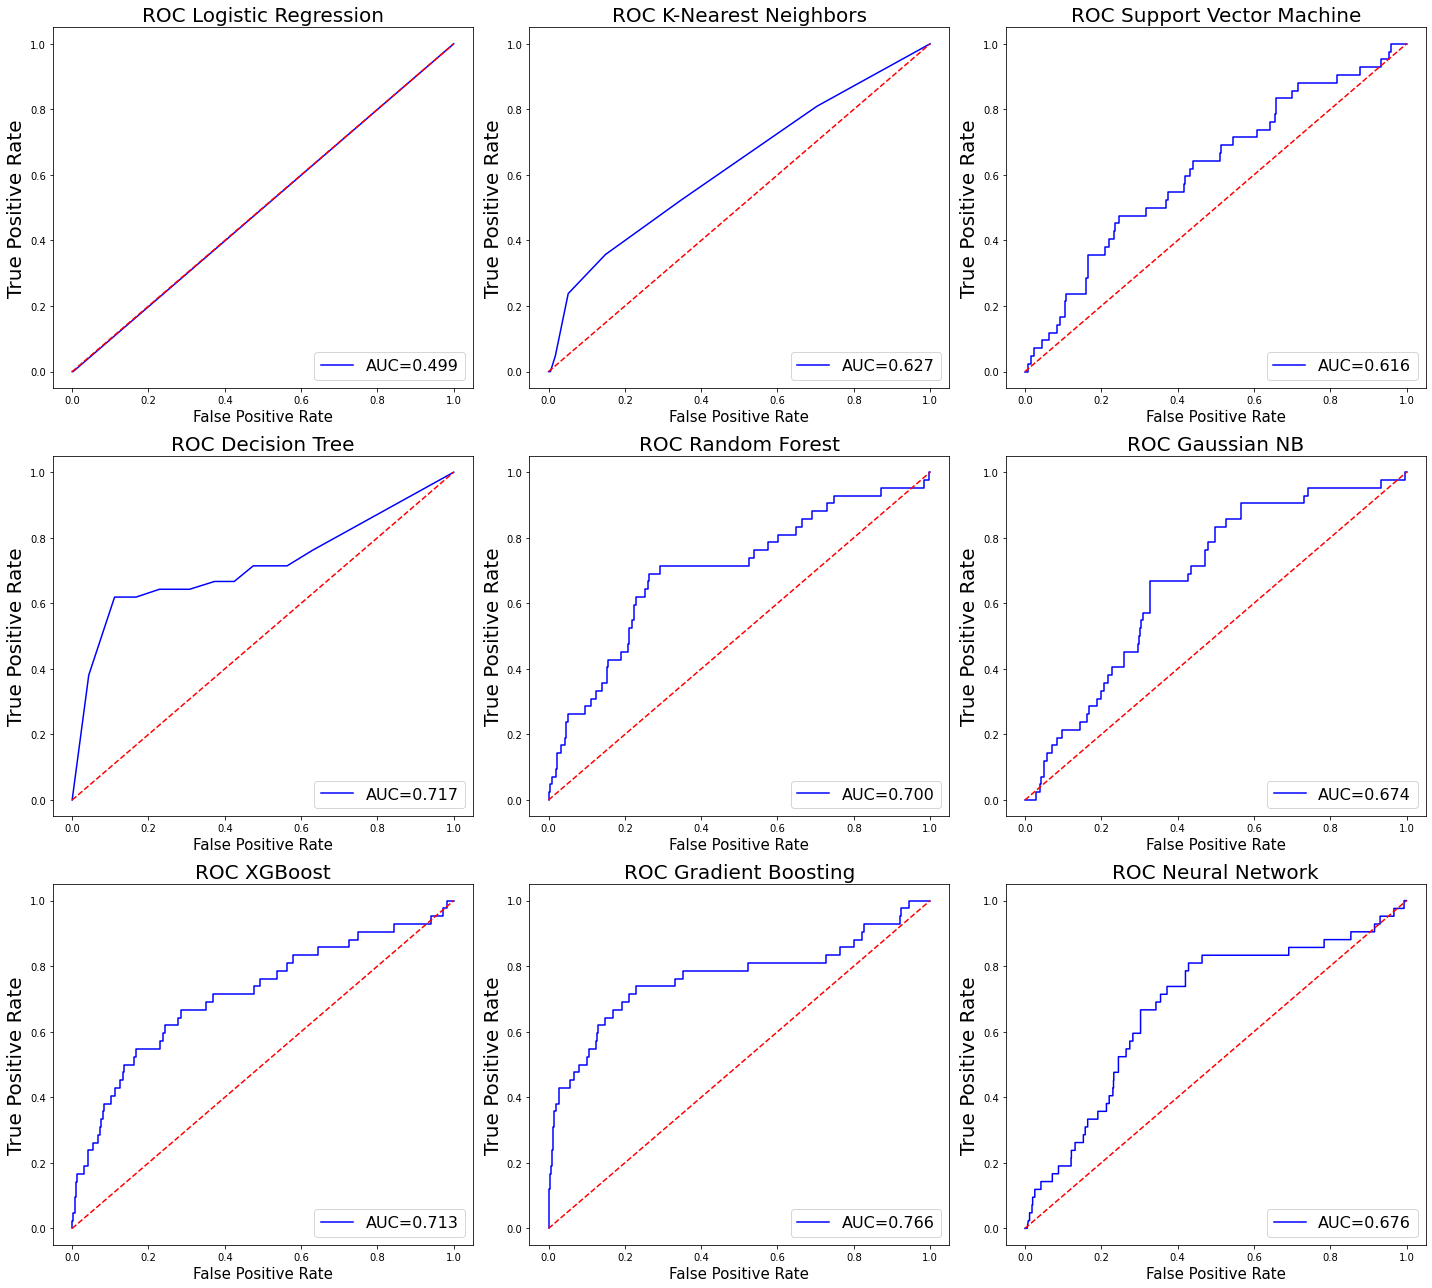

In [35]:
n_col=3
n_row=int(math.ceil(len(modelDict)/n_col))

fig, ax_arr = plt.subplots(nrows = n_row, ncols = n_col, figsize = (20,n_row*6))
for i, (model_name,model) in enumerate(modelDict.items()):
    i_row=i//n_col
    i_col=i%n_col
    draw_auc_curve(ax_arr[i_row,i_col], model_name, modelNameDict, results_test)

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

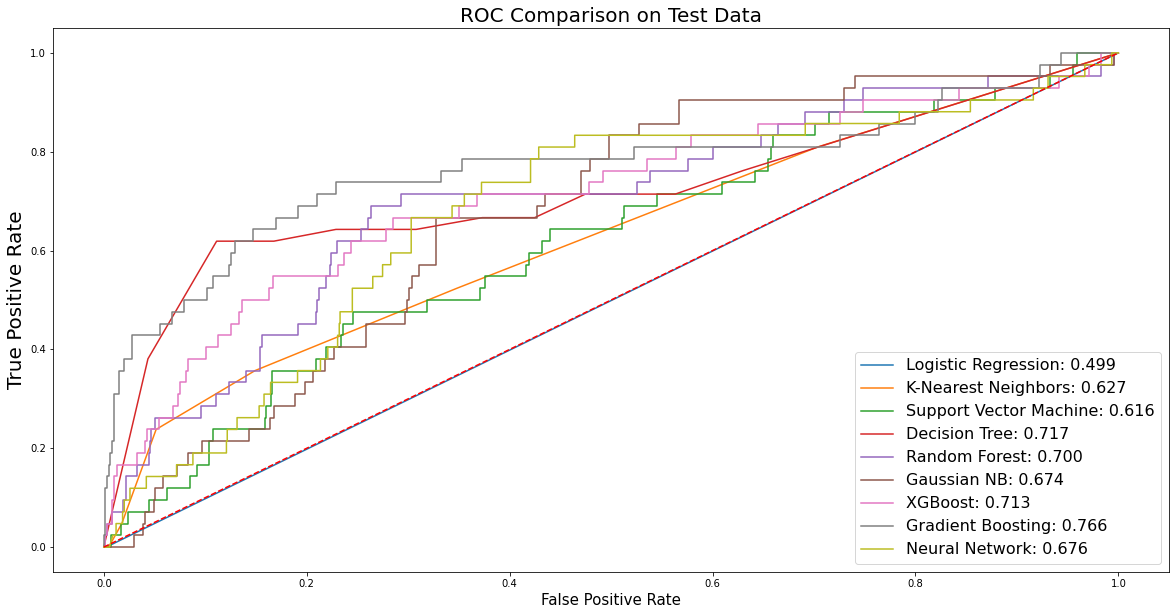

In [36]:
plt.figure(figsize=(20,10))
for model_name, col_name in modelNameDict.items():
    preds=results_test[col_name]
    fpr, tpr, threshold = metrics.roc_curve(y_test,preds)
    roc_auc=metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f"{model_name}: {roc_auc:.3f}")

plt.plot([0, 1], [0, 1],'r--')
ax=plt.gca()
ax.set_title("ROC Comparison on Test Data",fontsize=20)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

In [123]:
models = pd.DataFrame({
                'Models': ['Random Forest Classifier', 'Decision Tree Classifier', 'Support Vector Machine',
                           'K-Near Neighbors', 'Logistic Model', 'Gaussian NB', 'XGBoost', 'Gradient Boosting', 'NN'],
                'Accuracy':  [RFCCV, DTREECV, SVCCV, KNNCV, LOGCV, GAUSSIANCV, XGBCV, GBKCV, NNCV],
'Train AUC':  [RFCCV_tr, DTREECV_tr, SVCCV_tr, KNNCV_tr, LOGCV_tr, GAUSSIANCV_tr, XGBCV_tr, GBKCV_tr, NNCV_tr],
'Test AUC':  [RFCCV_te, DTREECV_te, SVCCV_te, KNNCV_te, LOGCV_te, GAUSSIANCV_te, XGBCV_te, GBKCV_te, NNCV_te],
'F1':  [RFCCV_f, DTREECV_f, SVCCV_f, KNNCV_f, LOGCV_f, GAUSSIANCV_f, XGBCV_f, GBKCV_f, NNCV_f]})

models.sort_values(by='F1', ascending=False)

,Models,Accuracy,Train AUC,Test AUC,F1
0,NN,0.662439,0.522116,0.496777,0.321680
1,XGBoost,0.875955,0.732567,0.713269,0.167264
2,Gradient Boosting,0.861397,0.958767,0.761463,0.136352
3,Gaussian NB,0.738605,0.700761,0.673612,0.071478
4,Logistic Model,0.661752,0.510901,0.498578,0.000000
5,Support Vector Machine,0.756391,0.654239,0.616035,0.000000
6,K-Near Neighbors,0.815766,0.675866,0.627029,0.000000
7,Random Forest Classifier,0.829687,0.687152,0.699628,0.000000
8,Decision Tree Classifier,0.726353,0.701530,0.716578,0.000000


In [124]:
gaussiannb= GaussianNB('var_smoothing': 0.1)
gaussiannb.fit(X_train, y_train)
gaussiannbpred = gaussiannb.predict_proba(X_test)[:,1]
probs = gaussiannb.predict_proba(X_test)[:,1]
GAUSSIANCV = (cross_val_score(gaussiannb, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
results_train['NB'] = gaussiannb.predict_proba(X_train)[:,1]
results_test['NB'] = gaussiannbpred

GAUSSIANCV_tr = metrics.roc_auc_score(y_train, gaussiannb.predict_proba(X_train)[:,1])
GAUSSIANCV_te = metrics.roc_auc_score(y_test, gaussiannb.predict_proba(X_test)[:,1])

y_test_pred = gaussiannb.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

GAUSSIANCV_f = metrics.f1_score(y_test, y_test_pred)

In [125]:
xb = XGBClassifier(max_depth=4,eval_metric='auc',min_child_weight=5,'eta':0.1)
xb.fit(X_train, y_train)
XGBCV = (cross_val_score(estimator = xb, X = X_train, y = y_train, cv = 10).mean())
results_train['xgb'] = xb.predict_proba(X_train)[:,1]
results_test['xgb'] = xb.predict_proba(X_test)[:,1]

XGBCV_tr = metrics.roc_auc_score(y_train, xb.predict_proba(X_train)[:,1])
XGBCV_te = metrics.roc_auc_score(y_test, xb.predict_proba(X_test)[:,1])

y_test_pred = xb.predict_proba(X_test)[:,1]
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<0.5]=0

XGBCV_f = metrics.f1_score(y_test, y_test_pred)

In [127]:
model_com = pd.DataFrame({
                'Models': ['XGBoost', 'Gaussian NB'],
                'Accuracy':  [XGBCV, GAUSSIANCV],
'Train AUC':  [XGBCV_tr, GAUSSIANCV_tr],
'Test AUC':  [XGBCV_te, GAUSSIANCV_te],
'F1':  [XGBCV_f, GAUSSIANCV_f]})

model_com

,Models,Accuracy,Train AUC,Test AUC,F1
0,XGBoost,0.887859,0.789236,0.789236,0.177264
1,Gaussian NB,0.746258,0.715648,0.715648,0.072962


In [33]:
for i in range(20):
    auc_rfc=[]
    xb = XGBClassifier(max_depth=3,eval_metric='auc',min_child_weight=5)
    xb.fit(X_train, y_train)
    XGBCV_te = metrics.roc_auc_score(y_test, xb.predict_proba(X_test)[:,1])
    auc_rfc.append(XGBCV_te)

for i in range(20):
    auc_xb=[]
    xb = XGBClassifier(max_depth=3,eval_metric='auc',min_child_weight=5)
    xb.fit(X_train, y_train)
    RFCCV_te = metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])
    auc_xb.append(RFCCV_te)
auc_te = pd.DataFrame({'XGBoost':auc_xb,'Random Forest':auc_rfc})

In [46]:
auc_te

,XGBoost,Random Forest
0,0.674993,0.683402
1,0.715826,0.707415
2,0.705322,0.710623
3,0.722743,0.693361
4,0.668290,0.693246
5,0.740083,0.719471
6,0.741567,0.645350
7,0.692842,0.736524
8,0.662721,0.658798
9,0.684959,0.717751


In [47]:
diff = []
for i in auc_te.XGBoost:
    for j in auc_te['Random Forest']:
        diff.append(i-j)
print(stats.ttest_1samp(diff, 0.0))
s, p = stats.ttest_1samp(diff, 0.0)
if (1 - p/2) >= 0.05:
    print('cannot reject h0')
else:
    print('can reject h0')   

Ttest_1sampResult(statistic=6.613954828043137, pvalue=1.2049726812597405e-10)
cannot reject h0


In [27]:
features = X_train.columns
pd.DataFrame({'feature': features, 'importance': xb.feature_importances_}).\
sort_values('importance', ascending=False).reset_index(drop=True)

,feature,importance
3,LDA_3,0.342429
11,polarity,0.270381
1,LDA_1,0.146279
2,LDA_2,0.091189
0,review_stars,0.031021
7,LDA_7,0.028823
10,LDA_10,0.026032
5,LDA_5,0.015203
9,LDA_9,0.013033
4,LDA_4,0.012224


In [34]:
features = X.columns
pd.DataFrame({'feature': features, 'importance': rfc.feature_importances_}).\
sort_values('importance', ascending=False).reset_index(drop=True)

,feature,importance
0,review_stars,0.325776
2,LDA_2,0.284999
1,LDA_1,0.126054
11,polarity,0.082911
7,LDA_7,0.052072
3,LDA_3,0.032282
5,LDA_5,0.021307
9,LDA_9,0.020096
8,LDA_8,0.018932
10,LDA_10,0.012198
